In [25]:
import mne
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal


In [26]:
# Taking our raw files before and after the arethematic task which define our rest and task state 
# we take file subject number 23 for this code to compare them side by side

rest_raw_files = mne.io.read_raw_edf('DATASETS/Subject23_1.edf',preload=True)
task_raw_files = mne.io.read_raw_edf('DATASETS/Subject23_2.edf',preload=True)

Extracting EDF parameters from C:\Users\RAHUL DIXIT\Desktop\EEG\DATASETS\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from C:\Users\RAHUL DIXIT\Desktop\EEG\DATASETS\Subject23_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


In [27]:
rest_raw_files.describe()

<RawEDF | Subject23_1.edf, 21 x 91000 (182.0 s), ~14.6 MB, data loaded>
ch  name       type  unit        min         Q1     median         Q3        max
 0  EEG Fp1    EEG   µV       -64.70      -7.73       0.32       8.05      47.15
 1  EEG Fp2    EEG   µV       -75.21      -8.86       0.34       9.27      56.94
 2  EEG F3     EEG   µV       -44.17      -7.35       0.11       7.55      51.06
 3  EEG F4     EEG   µV       -45.86      -7.56       0.00       7.67      50.99
 4  EEG F7     EEG   µV       -49.07      -7.54       0.10       7.88      42.47
 5  EEG F8     EEG   µV       -45.48      -6.74      -0.00       6.88      42.43
 6  EEG T3     EEG   µV       -38.46      -7.02      -0.02       6.96      44.58
 7  EEG T4     EEG   µV       -34.95      -5.81       0.00       5.74      38.98
 8  EEG C3     EEG   µV       -39.98      -7.23       0.00       7.09      47.59
 9  EEG C4     EEG   µV       -45.71      -7.49      -0.06       7.14      56.53
10  EEG T5     EEG   µV       -35.39 

In [28]:
print(rest_raw_files.info)
print(task_raw_files.info)

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2010-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2010-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: 4 items (dict)
>


In [29]:
l_freq, h_freq = 1,100
# defining the upper and lower limit of our frequency filter 

rest_raw_files.filter(l_freq,h_freq)

task_raw_files.filter(l_freq,h_freq)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<RawEDF | Subject23_2.edf, 21 x 31000 (62.0 s), ~5.0 MB, data loaded>

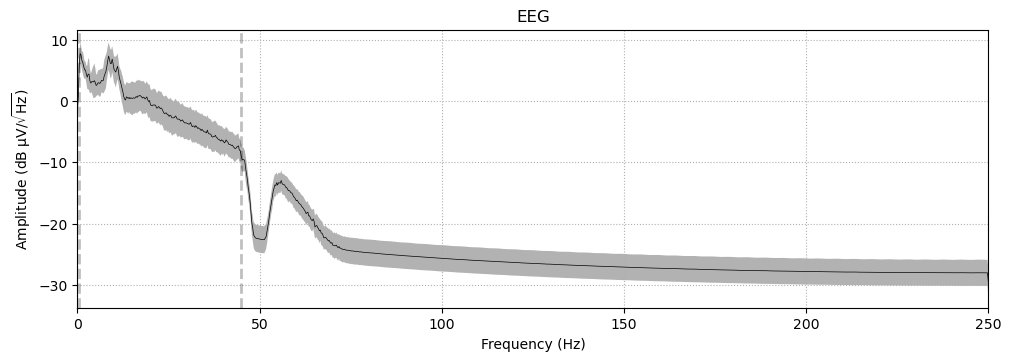

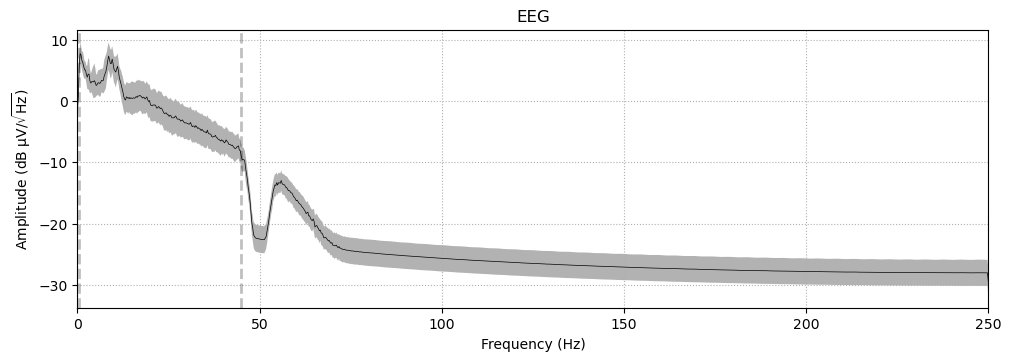

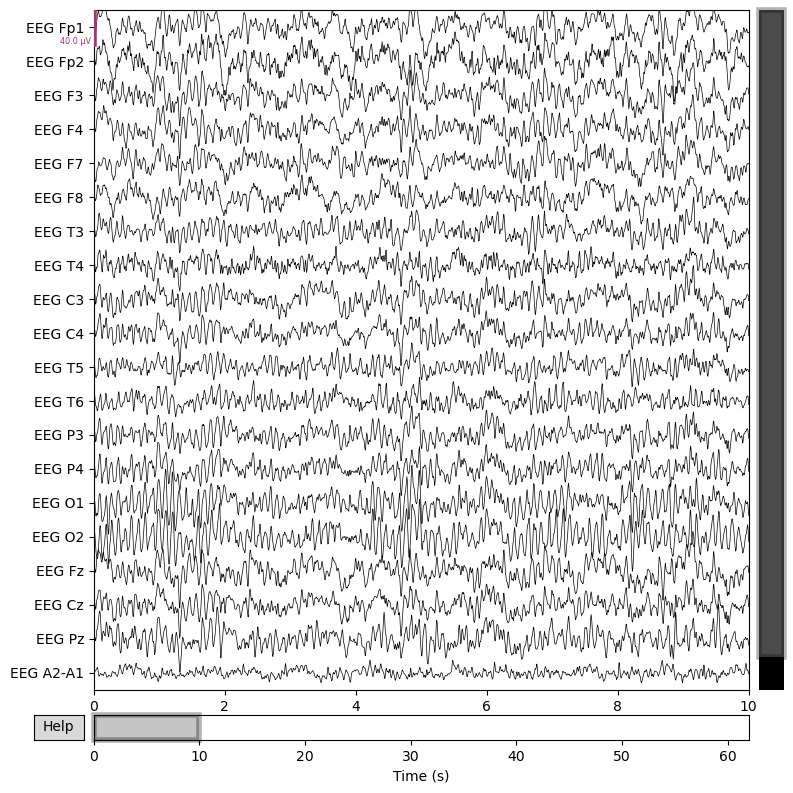

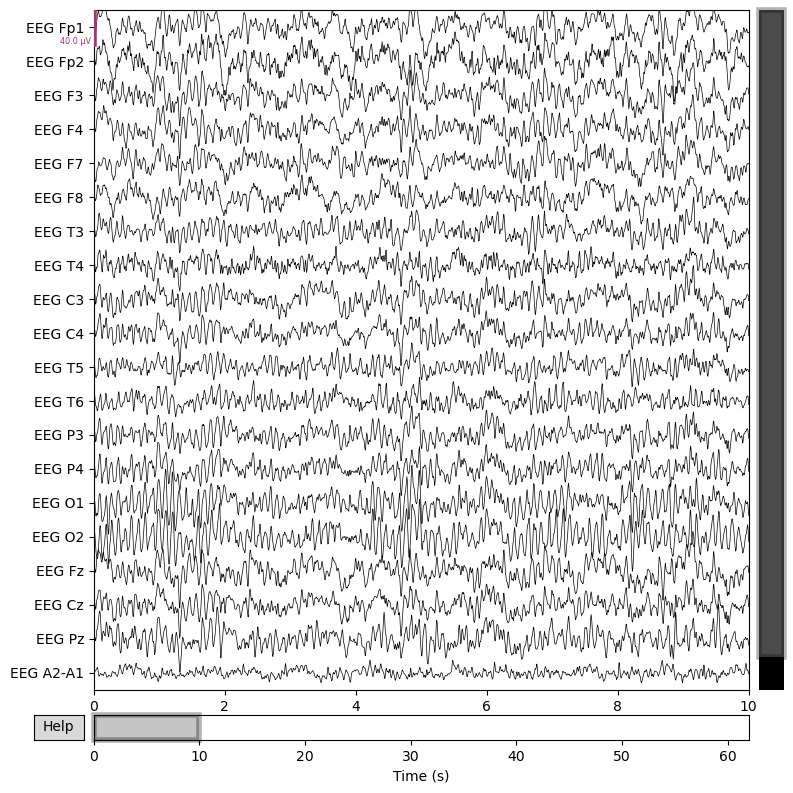

In [30]:
task_raw_files.plot(n_channels=20)

In [31]:
# selecting the necessary eeg channels
# we will not need meg data so False 

eeg_channels = mne.pick_types(rest_raw_files.info , meg= False , eeg=True , exclude='bads')

channel_name= rest_raw_files.ch_names

In [32]:
def calculate_psd(raw, fmin=1, fmax=100):
  data = raw.get_data()  # Get data as a NumPy array

  # Calculate PSD using psd_array_welch
  
  # define the sampling frequency beforehand
  sfreq = raw.info['sfreq'] 
  psds, freqs = mne.time_frequency.psd_array_welch(
      data, fmin=fmin, fmax=fmax, n_fft=int(sfreq * 4), n_overlap=int(sfreq * 2), verbose=False,sfreq=sfreq)

  return psds, freqs

In [33]:
# Calculating the PSDs
rest_psds, rest_freqs = calculate_psd(rest_raw_files)
task_psds, task_freqs = calculate_psd(task_raw_files)

In [34]:
# extracting band wise psd 

def extract_band_power(psds, freqs, band_range):
    freq_res = freqs[1] - freqs[0]
    band_idx = np.logical_and(freqs >= band_range[0], freqs <= band_range[1])
    band_power = np.sum(psds[:, band_idx], axis=1) * freq_res
    return band_power

# defining the band ranges for alpha theta beta gamma delta
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

rest_band_power = {band: extract_band_power(rest_psds, rest_freqs, freq_range) 
                   for band, freq_range in bands.items()}
task_band_power = {band: extract_band_power(task_psds, task_freqs, freq_range) 
                   for band, freq_range in bands.items()}

In [35]:
def extract_band_power(psds, freqs, band_range):
    freq_res = freqs[1] - freqs[0]
    band_idx = np.logical_and(freqs >= band_range[0], freqs <= band_range[1])
    band_power = np.sum(psds[:, band_idx], axis=1) * freq_res
    # Convert to a more appropriate scale if necessary
    return band_power * 1e12  # Convert to pico-watts, for example

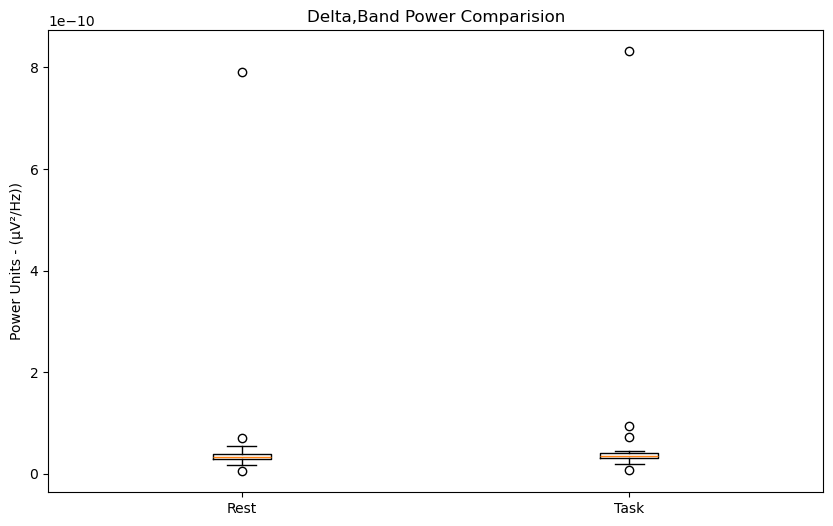

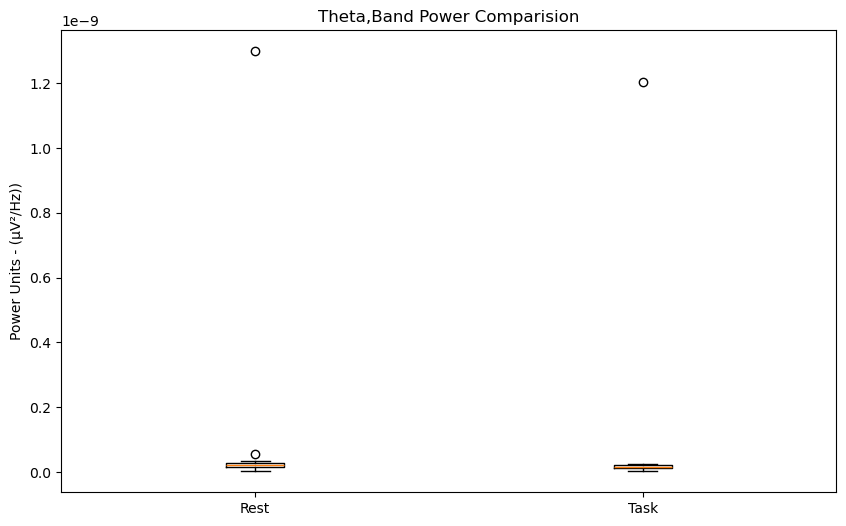

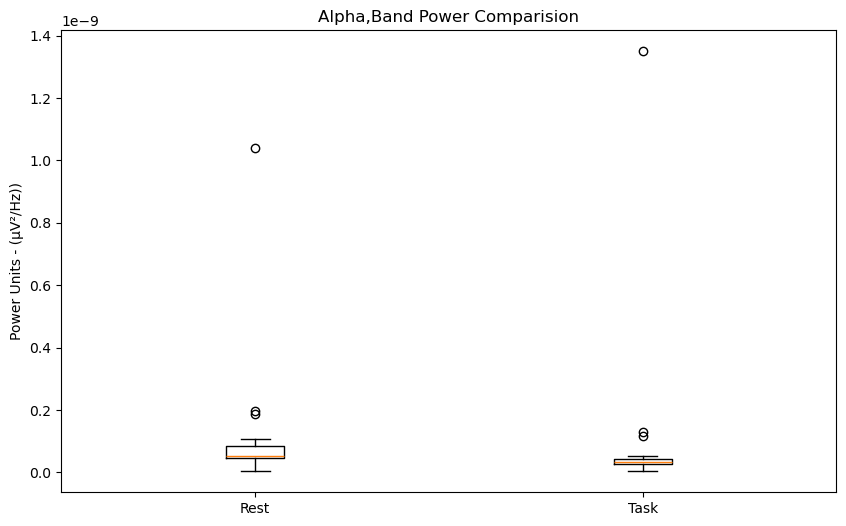

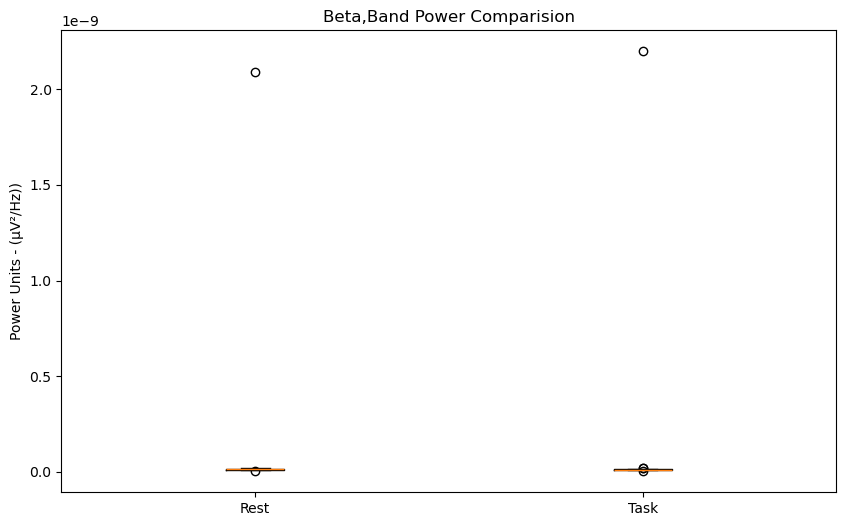

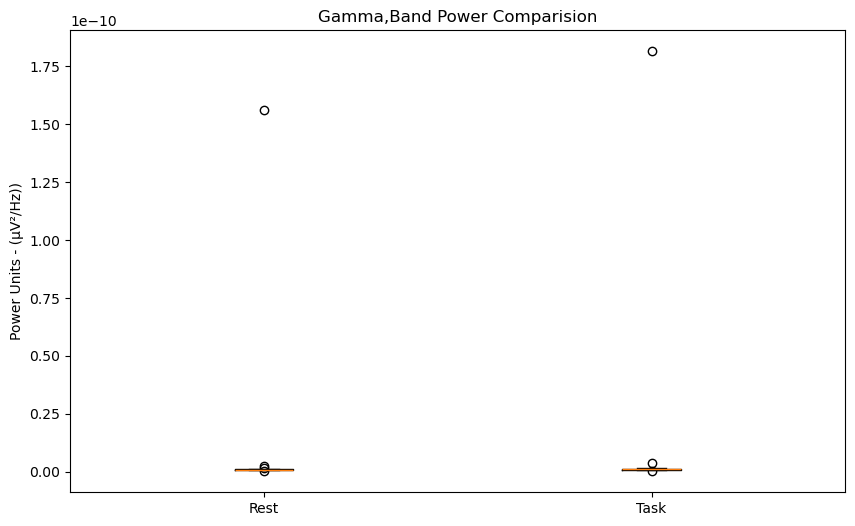

In [36]:
#printing the band psd and visualisiing the data 

def band_comparision(rest_power,task_power,band_name):
    plt.figure(figsize=(10,6))
    plt.boxplot([rest_power,task_power],labels=['Rest', 'Task'])
    plt.title(f"{band_name},Band Power Comparision")
    plt.ylabel("Power Units - (µV²/Hz))")
    plt.show()
    

for band in bands.keys():
    band_comparision(rest_band_power[band],task_band_power[band],band)

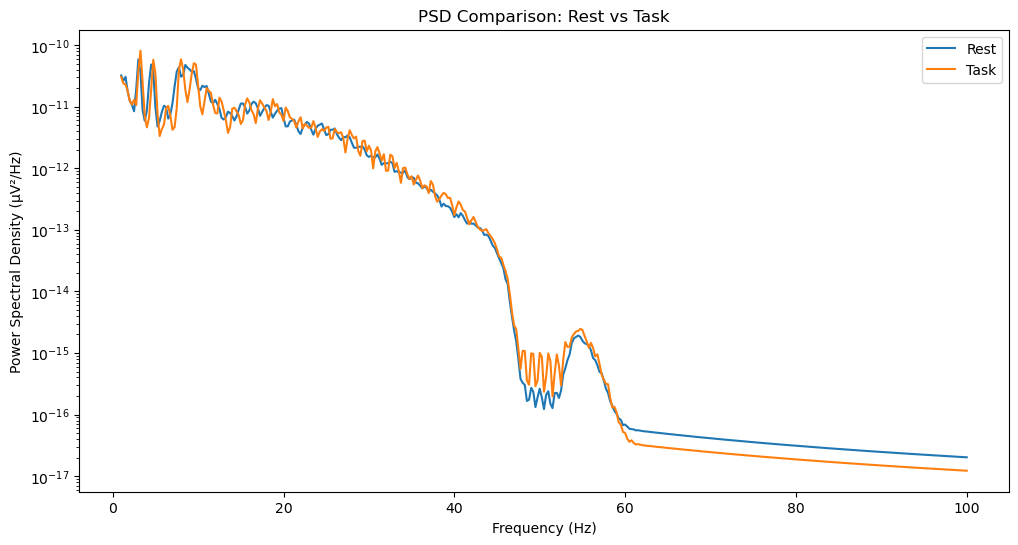

In [37]:

# Plot overall PSD comparison
plt.figure(figsize=(12, 6))
plt.semilogy(rest_freqs, rest_psds.mean(axis=0), label='Rest')
plt.semilogy(task_freqs, task_psds.mean(axis=0), label='Task')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.title('PSD Comparison: Rest vs Task')
plt.legend()
plt.show()

In [38]:
## Creating a s summary of my findings - 

def summarize_findings(rest_power, task_power):
    for band in bands.keys():
        rest_mean = np.mean(rest_power[band])
        task_mean = np.mean(task_power[band])
        percent_change = ((task_mean - rest_mean) / rest_mean) * 100
        
        print(f"{band} Band:")
        print(f"  Rest mean power: {rest_mean:.2f} µV²/Hz")
        print(f"  Task mean power: {task_mean:.2f} µV²/Hz")
        print(f"  Percent change: {percent_change:.2f}%")
        print()

summarize_findings(rest_band_power, task_band_power)

Delta Band:
  Rest mean power: 0.00 µV²/Hz
  Task mean power: 0.00 µV²/Hz
  Percent change: 7.78%

Theta Band:
  Rest mean power: 0.00 µV²/Hz
  Task mean power: 0.00 µV²/Hz
  Percent change: -12.17%

Alpha Band:
  Rest mean power: 0.00 µV²/Hz
  Task mean power: 0.00 µV²/Hz
  Percent change: -10.03%

Beta Band:
  Rest mean power: 0.00 µV²/Hz
  Task mean power: 0.00 µV²/Hz
  Percent change: 3.05%

Gamma Band:
  Rest mean power: 0.00 µV²/Hz
  Task mean power: 0.00 µV²/Hz
  Percent change: 14.52%



## Conclusions - 

1. The overall mean power values of the bands in both rest and task are very low that is why they give out 0.00 in each case 
2. The maximum relative change in each band is of gamma band and the lowest absolute change value that is noticed is of beta bands(3.04 percent)
3. Beta bands is often associated with active thinking so the small increase can be justified 
4. Gamma bands show the maximum change which displays highest cognitive engagement so this is also valid to show so varied values 
5. The decreases in theta and alpha band activity suggest a shift from a relaxed state to a more mentally engaged state during the task.
6. The slight increase in beta activity and more substantial increase in delta activity might indicate increased focus and mental effort during the task.
7. Absolute power being 0.00 in all cases defines a scaling problem 

### Also Indivisually plotting the psd for each raw and task edf files for in general view 

In [42]:
data_rest = mne.io.read_raw_edf('DATASETS/Subject23_1.edf')

Extracting EDF parameters from C:\Users\RAHUL DIXIT\Desktop\EEG\DATASETS\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Effective window size : 4.096 (s)
Plotting amplitude spectral density (dB=True).


D:\Anaconda\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


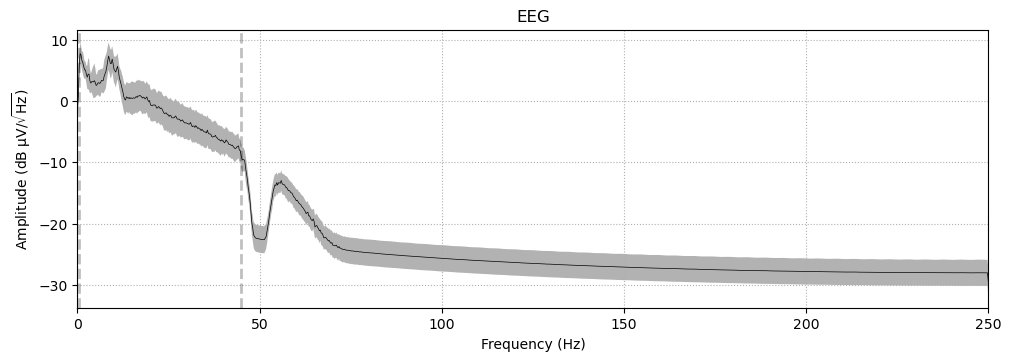

In [43]:
spectrum1 = data_rest.compute_psd()
spectrum1.plot(average = True , picks = 'data',exclude = 'bads',amplitude = True ,spatial_colors='blue')

Extracting EDF parameters from C:\Users\RAHUL DIXIT\Desktop\EEG\DATASETS\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Effective window size : 4.096 (s)
Plotting amplitude spectral density (dB=True).


D:\Anaconda\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


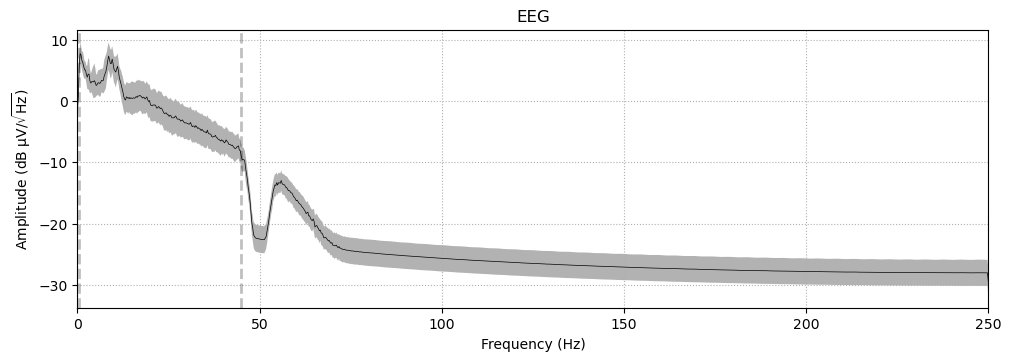

In [44]:
data_task = mne.io.read_raw_edf('DATASETS/Subject23_1.edf')
spectrum2= data_task.compute_psd()
spectrum1.plot(average = True , picks = 'data',exclude = 'bads',amplitude = True ,spatial_colors='blue')

## 2. Federated Learning :

## --Each client will run down the following Model Locally and
##   then it will sent it to the Central Server.

In [48]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

def load_and_preprocess(file_path, l_freq=1, h_freq=100):
    """Loads and preprocesses EEG data from a given file path."""
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.filter(l_freq, h_freq)
    return raw

def calculate_psd(raw, fmin=1, fmax=100):
    """Calculates Power Spectral Density (PSD) using Welch's method."""
    data = raw.get_data()
    sfreq = raw.info['sfreq']
    psds, freqs = mne.time_frequency.psd_array_welch(
        data, fmin=fmin, fmax=fmax, n_fft=int(sfreq * 4), n_overlap=int(sfreq * 2), verbose=False, sfreq=sfreq
    )
    return psds, freqs

def extract_band_power(psds, freqs, band_range):
    """Extracts power in specified frequency bands."""
    freq_res = freqs[1] - freqs[0]
    band_idx = np.logical_and(freqs >= band_range[0], freqs <= band_range[1])
    band_power = np.sum(psds[:, band_idx], axis=1) * freq_res
    return band_power

def process_eeg_data(file_paths):
    """Processes a list of EEG files and extracts band power features."""
    features = []
    for file_path in file_paths:
        raw = load_and_preprocess(file_path)
        psds, freqs = calculate_psd(raw)
        bands = {
            'Delta': (1, 4),
            'Theta': (4, 8),
            'Alpha': (8, 12),
            'Beta': (12, 30),
            'Gamma': (30, 100)
        }
        band_power = {band: extract_band_power(psds, freqs, freq_range) for band, freq_range in bands.items()}
        features.append(band_power)
    return features

# Client-side function to extract features locally
rest_file = 'DATASETS/Subject23_1.edf'
task_file = 'DATASETS/Subject23_2.edf'
client_features = process_eeg_data([rest_file, task_file])

Extracting EDF parameters from C:\Users\RAHUL DIXIT\Desktop\EEG\DATASETS\Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\RAHUL DIXIT\Desktop\EEG\DATASETS\Subject23_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Server Side --

In [60]:
def aggregate_client_updates(client_updates):
    """Aggregates the updates from clients."""
    aggregated_update = np.mean(client_updates, axis=0)
    return aggregated_update

# Example of aggregation of band power features
# Assume we have features from multiple clients
client_updates = [client_features_1, client_features_2, client_features_3]  # Simulated client features
global_update = aggregate_client_updates(client_updates)